# GTI DIRINT Examples

This notebook shows a few examples of the pvlib python implementation of the GTI DIRINT algorithm.

Authors: Will Holmgren (@wholmgren), University of Arizona (2017, 2018).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 8, 5
mpl.rcParams['figure.dpi'] = 100

import pandas as pd
import numpy as np

import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.tracking import SingleAxisTracker
from pvlib.tools import cosd

pvlib.__version__

'0.5.2+71.g0b83533.dirty'

In [2]:
from importlib import reload

Use a clear sky algorithm to generate some POA data.

Choose a tilt angle and times for which we'll see AOI > 90.

In [3]:
freq = '5min'  # 5min is the finest resolution tested in Marion 2015

times = pd.DatetimeIndex(start='20160606', end='20160607', tz='America/Phoenix', freq=freq)

In [4]:
location = Location(32.2, -110.9, altitude=700)

In [5]:
pressure = pvlib.atmosphere.alt2pres(location.altitude)

In [6]:
solpos = location.get_solarposition(times)

In [7]:
cs = location.get_clearsky(times, solar_position=solpos)

In [8]:
dni, ghi, dhi = cs['dni'], cs['ghi'], cs['dhi']

In [9]:
solar_zenith, solar_azimuth = solpos['zenith'], solpos['azimuth']

In [10]:
surface_tilt = 40
surface_azimuth = 180
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth)

In [11]:
aoi = system.get_aoi(solar_zenith, solar_azimuth)

In [12]:
# note that this method will use the haydavies transposition model by default,
# however the gti_dirint function will use perez by default.
all_irrad = system.get_irradiance(solar_zenith, solar_azimuth, dni, ghi, dhi)

In [13]:
poa_global = all_irrad['poa_global']

Text(0,0.5,'AOI (deg)')

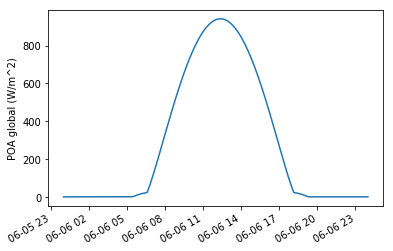

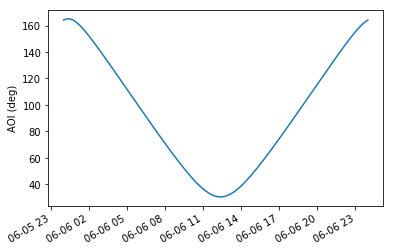

In [14]:
poa_global.plot()
plt.ylabel('POA global (W/m^2)')

plt.figure()
aoi.plot()
plt.ylabel('AOI (deg)')

In [15]:
aoi_lt_90 = aoi < 90
month = 6
color = ['b', 'g', 'r']

In [16]:
# pvlib = reload(pvlib)
# pvlib.irradiance = reload(pvlib.irradiance)

In [17]:
temp_dew = pd.Series(0, index=aoi.index)
model_perez = 'phoenix1988'

Here's the basic usage of the GTI DIRINT model

In [18]:
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global, aoi, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth,
    pressure=pressure,
    use_delta_kt_prime=True, temp_dew=temp_dew, albedo=.25,
    model='perez', model_perez=model_perez,
    calculate_gt_90=True, max_iterations=30)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1915: RuntimeWarning: invalid value encountered in maximum
  disc_dni = np.maximum(_disc_kn(kt, airmass) * I0, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1272: RuntimeWarning: invalid value encountered in maximum
  kt_prime = np.maximum(kt_prime, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1273: RuntimeWarning: invalid value encountered in minimum
  kt_prime = np.minimum(kt_prime, max_clearness_index)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1927: RuntimeWarning: invalid value encountered in maximum
  dni = np.maximum(dni, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1929: RuntimeWarning: invalid value encountered in maximum
  dhi = np.maximum(dhi, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1137: RuntimeWarning: invalid value encountered in maximum
  F1 = np.maximum(F1, 0)
/Users/holmgren/git_repo

Plot the data

Text(0.5,1,'Month=6. GTI DIRINT ghi (solid) vs. Original ghi (dashed)')

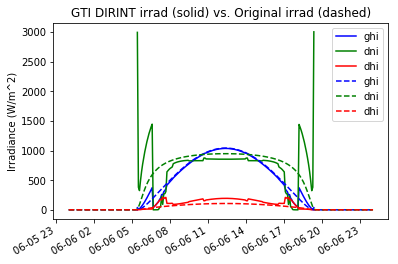

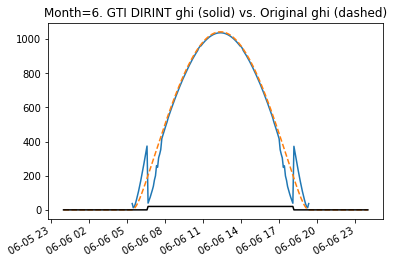

In [19]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax, color=color)
cs.plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
gti_dirint_out['ghi'].plot(ax=ax)
cs.loc[gti_dirint_out.index]['ghi'].plot(ax=ax, ls='--')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

Looks good for the middle of the day. Not so good for AOI > 80. Problems:

* DNI exploads at sunrise/sunset
* DNI and GHI too high for AOI > 90
* DNI and GHI too low for approx 80 < AOI < 90.

The `debug` kwarg will let us investigate...

In [20]:
best_ghi, best_dni, best_dhi, best_kt_prime, all_irrad, poa_global_i, kt, kt_prime, best_diff = pvlib.irradiance._gti_dirint_lt_90(
    poa_global, aoi, aoi_lt_90, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth, pressure=pressure,
    use_delta_kt_prime=True, temp_dew=temp_dew, albedo=.25,
    model='perez', model_perez=model_perez,
    max_iterations=30, debug=True)

gti_dirint_out = pd.DataFrame(dict(zip(('ghi', 'dni', 'dhi'), (best_ghi, best_dni, best_dhi))))

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1915: RuntimeWarning: invalid value encountered in maximum
  disc_dni = np.maximum(_disc_kn(kt, airmass) * I0, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1272: RuntimeWarning: invalid value encountered in maximum
  kt_prime = np.maximum(kt_prime, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1273: RuntimeWarning: invalid value encountered in minimum
  kt_prime = np.minimum(kt_prime, max_clearness_index)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1927: RuntimeWarning: invalid value encountered in maximum
  dni = np.maximum(dni, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1929: RuntimeWarning: invalid value encountered in maximum
  dhi = np.maximum(dhi, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1137: RuntimeWarning: invalid value encountered in maximum
  F1 = np.maximum(F1, 0)
/Users/holmgren/git_repo

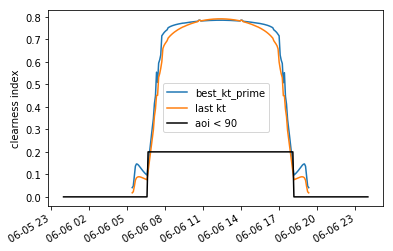

In [21]:
best_kt_prime.plot(label='best_kt_prime')
kt.plot(label='last kt')
(aoi_lt_90 * .20).loc[gti_dirint_out.index].plot(color='k', label='aoi < 90')
plt.ylabel('clearness index')
plt.legend()

For clear times, we'd expect kt and kt_prime to be ~0.8, but that is not the case for AOI > 80.

calculate kt manually...

In [22]:
extra_radiation = pvlib.irradiance.get_extra_radiation(times)
airmass = pvlib.atmosphere.get_relative_airmass(solar_zenith, model='kasten1966')
airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)

clearness_index = pvlib.irradiance.clearness_index(poa_global, aoi, extra_radiation)
clearness_index_zenith_independent = pvlib.irradiance.clearness_index_zenith_independent(clearness_index, airmass)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1272: RuntimeWarning: invalid value encountered in maximum
  kt_prime = np.maximum(kt_prime, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1273: RuntimeWarning: invalid value encountered in minimum
  kt_prime = np.minimum(kt_prime, max_clearness_index)


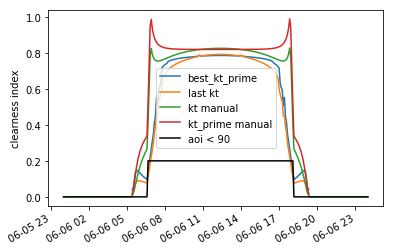

In [23]:
best_kt_prime.plot(label='best_kt_prime')
kt.plot(label='last kt')
clearness_index.plot(label='kt manual')
clearness_index_zenith_independent.plot(label='kt_prime manual')
(aoi_lt_90 * .20).loc[gti_dirint_out.index].plot(color='k', label='aoi < 90')
plt.ylabel('clearness index')
plt.legend()

turn off the iterative algorithm and see what happens...

In [24]:
best_ghi, best_dni, best_dhi, best_kt_prime, all_irrad, poa_global_i, kt, kt_prime, best_diff = pvlib.irradiance._gti_dirint_lt_90(
    poa_global, aoi, aoi_lt_90, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth, pressure=pressure,
    use_delta_kt_prime=True, temp_dew=temp_dew, albedo=.25,
    model='perez', model_perez=model_perez,
    max_iterations=1, debug=True)

gti_dirint_out = pd.DataFrame(dict(zip(('ghi', 'dni', 'dhi'), (best_ghi, best_dni, best_dhi))))

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1915: RuntimeWarning: invalid value encountered in maximum
  disc_dni = np.maximum(_disc_kn(kt, airmass) * I0, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1272: RuntimeWarning: invalid value encountered in maximum
  kt_prime = np.maximum(kt_prime, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1273: RuntimeWarning: invalid value encountered in minimum
  kt_prime = np.minimum(kt_prime, max_clearness_index)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1927: RuntimeWarning: invalid value encountered in maximum
  dni = np.maximum(dni, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1929: RuntimeWarning: invalid value encountered in maximum
  dhi = np.maximum(dhi, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1137: RuntimeWarning: invalid value encountered in maximum
  F1 = np.maximum(F1, 0)
/Users/holmgren/git_repo

warnings about difference between gti_modeled and input poa_global, but that's to be expected.

what does GHI look like?

Text(0.5,1,'Month=6. GTI DIRINT ghi (solid) vs. Original ghi (dashed)')

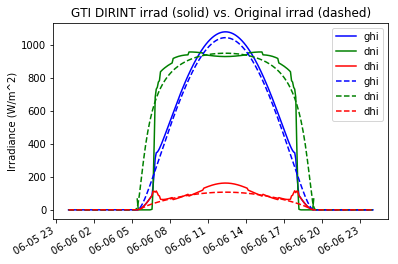

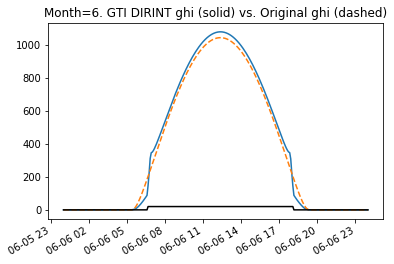

In [25]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax, color=color)
cs.plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
gti_dirint_out['ghi'].plot(ax=ax)
cs.loc[gti_dirint_out.index]['ghi'].plot(ax=ax, ls='--')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

worse for AOI < 80 but better for AOI > 80. how does kt look?

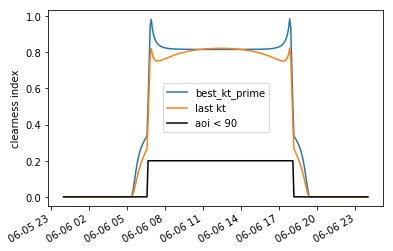

In [26]:
best_kt_prime.plot(label='best_kt_prime')
kt.plot(label='last kt')
(aoi_lt_90 * .20).loc[gti_dirint_out.index].plot(color='k', label='aoi < 90')
plt.ylabel('clearness index')
plt.legend()

kt looks clear.

plot the dataframe with POA components

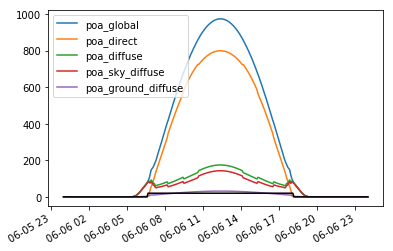

In [27]:
all_irrad.plot()
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')

Now look at GTI_measured (poa_global input), GTI_model (within the algorithm), and their difference (the convergence criteria).

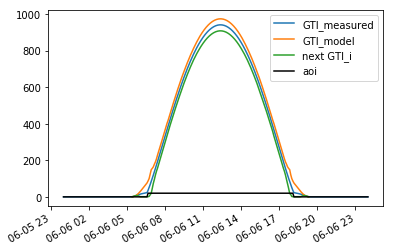

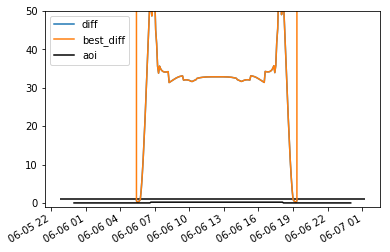

In [28]:
fig, ax = plt.subplots()
poa_global.plot(label='GTI_measured')
all_irrad['poa_global'].plot(label='GTI_model')
poa_global_i.plot(label='next GTI_i')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.legend()

fig, ax = plt.subplots()
(all_irrad['poa_global'] - poa_global).abs().plot(label='diff')
best_diff.plot(label='best_diff')
(aoi_lt_90 * .20).loc[gti_dirint_out.index].plot(color='k')
ax.set_ylim(-1, 50)
ax.hlines(1, *ax.get_xlim())
ax.legend()

What happens if we run GTI DIRINT with a small number of iterations?

In [29]:
best_ghi, best_dni, best_dhi, best_kt_prime, all_irrad, poa_global_i, kt, kt_prime, best_diff = pvlib.irradiance._gti_dirint_lt_90(
    poa_global, aoi, aoi_lt_90, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth, pressure=pressure,
    use_delta_kt_prime=True, temp_dew=temp_dew, albedo=.25,
    model='perez', model_perez=model_perez,
    max_iterations=3, debug=True)

gti_dirint_out = pd.DataFrame(dict(zip(('ghi', 'dni', 'dhi'), (best_ghi, best_dni, best_dhi))))

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1915: RuntimeWarning: invalid value encountered in maximum
  disc_dni = np.maximum(_disc_kn(kt, airmass) * I0, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1272: RuntimeWarning: invalid value encountered in maximum
  kt_prime = np.maximum(kt_prime, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1273: RuntimeWarning: invalid value encountered in minimum
  kt_prime = np.minimum(kt_prime, max_clearness_index)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1927: RuntimeWarning: invalid value encountered in maximum
  dni = np.maximum(dni, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1929: RuntimeWarning: invalid value encountered in maximum
  dhi = np.maximum(dhi, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1137: RuntimeWarning: invalid value encountered in maximum
  F1 = np.maximum(F1, 0)
/Users/holmgren/git_repo

Text(0.5,1,'Month=6. GTI DIRINT ghi (solid) vs. Original ghi (dashed)')

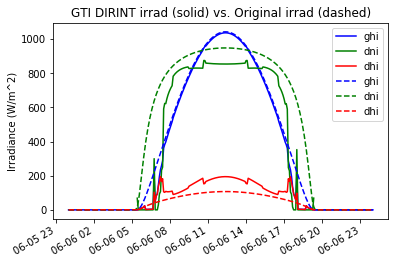

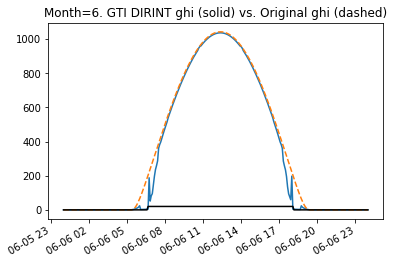

In [30]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax, color=color)
cs.plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
gti_dirint_out['ghi'].plot(ax=ax)
cs.loc[gti_dirint_out.index]['ghi'].plot(ax=ax, ls='--')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

GHI is getting worse (above). So is kt (below).

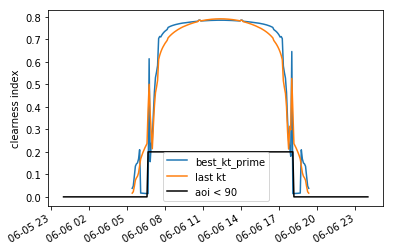

In [31]:
best_kt_prime.plot(label='best_kt_prime')
kt.plot(label='last kt')
(aoi_lt_90 * .20).loc[gti_dirint_out.index].plot(color='k', label='aoi < 90')
plt.ylabel('clearness index')
plt.legend()

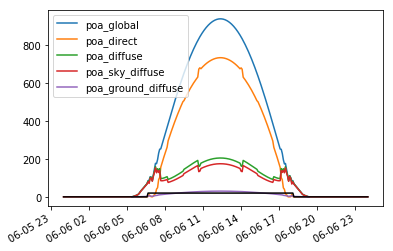

In [32]:
all_irrad.plot()
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')

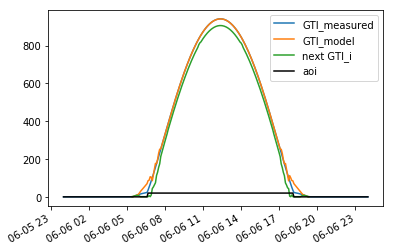

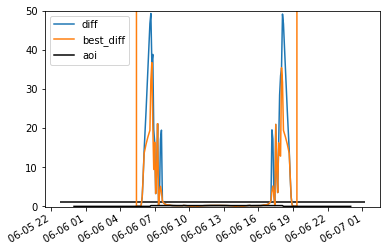

In [33]:
fig, ax = plt.subplots()
poa_global.plot(label='GTI_measured')
all_irrad['poa_global'].plot(label='GTI_model')
poa_global_i.plot(label='next GTI_i')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.legend()

fig, ax = plt.subplots()
(all_irrad['poa_global'] - poa_global).abs().plot(label='diff')
best_diff.plot(label='best_diff')
(aoi_lt_90 * .20).loc[gti_dirint_out.index].plot(color='k')
ax.set_ylim(-0.1, 50)
ax.hlines(1, *ax.get_xlim())
ax.legend()

The iterative algorithm is improving the difference between the modeled and measured POA, so it's doing it's job. Unfortunately this makes the modeled GHI worse at AOI > 80.

Older stuff below, including rerunning for different seasons.

Any warnings show the points for which the iterative algorithm failed to converge in the AOI < 90 case.

Looks ok overall, but not good near AOI = 90.

Text(0.5,1,'GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

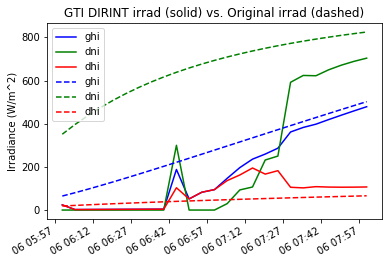

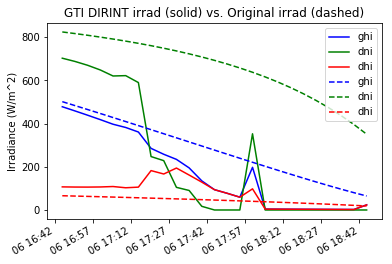

In [34]:
fig, ax = plt.subplots()
startend = '06:00', '08:00'
gti_dirint_out.between_time(*startend).plot(ax=ax, color=color)
cs.between_time(*startend).plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
startend = '16:45', '18:45'
gti_dirint_out.between_time(*startend).plot(ax=ax, color=color)
cs.between_time(*startend).plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

The model struggles for AOI between 80 and 90 degrees.

Run the model in only the middle of the day.

In [35]:
startend = '09:00', '15:00'
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global.between_time(*startend), aoi.between_time(*startend), 
    solar_zenith.between_time(*startend), solar_azimuth.between_time(*startend),
    solar_zenith.between_time(*startend).index, surface_tilt, surface_azimuth,
    pressure=pressure,
    use_delta_kt_prime=True, temp_dew=None, albedo=.25,
    model='perez', model_perez='allsitescomposite1990',
    calculate_gt_90=True, max_iterations=30)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:2000: RuntimeWarning: invalid value encountered in maximum
  disc_dni = np.maximum(_disc_kn(kt, airmass) * I0, 0)


Text(0.5,1,'Month=6. GTI DIRINT ghi (solid) vs. Original ghi (dashed)')

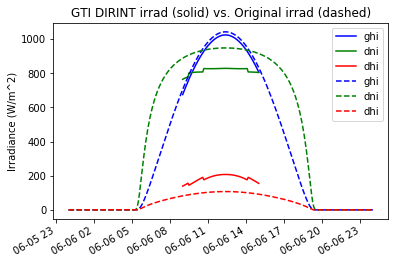

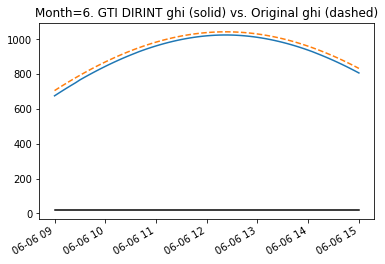

In [36]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax, color=color)
cs.plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
gti_dirint_out['ghi'].plot(ax=ax)
cs.loc[gti_dirint_out.index]['ghi'].plot(ax=ax, ls='--')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

Repeat for summer solstice, fall equinox, winter solstice.

In [37]:
times_jun = pd.DatetimeIndex(start='20160621', end='20160622', tz='America/Phoenix', freq=freq)
times_sep = pd.DatetimeIndex(start='20160921', end='20160922', tz='America/Phoenix', freq=freq)
times_dec = pd.DatetimeIndex(start='20161221', end='20161222', tz='America/Phoenix', freq=freq)

times = times_jun.append(times_sep).append(times_dec)

In [38]:
solpos = location.get_solarposition(times)

In [39]:
cs = location.get_clearsky(times, solar_position=solpos)

In [40]:
dni, ghi, dhi = cs['dni'], cs['ghi'], cs['dhi']

In [41]:
solar_zenith, solar_azimuth = solpos['zenith'], solpos['azimuth']

In [42]:
surface_tilt = 40
surface_azimuth = 180
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth)

In [43]:
aoi = system.get_aoi(solar_zenith, solar_azimuth)

In [44]:
# note that this method will use the haydavies transposition model by default,
# however the gti_dirint function will use perez by default.
all_irrad = system.get_irradiance(solar_zenith, solar_azimuth, dni, ghi, dhi)

In [45]:
poa_global = all_irrad['poa_global']

In [46]:
aoi_lt_90 = aoi < 90

In [47]:
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global, aoi, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth,
    pressure=pressure,
    use_delta_kt_prime=True, temp_dew=None, albedo=.25,
    model='perez', model_perez='allsitescomposite1990',
    calculate_gt_90=True, max_iterations=30)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1915: RuntimeWarning: invalid value encountered in maximum
  disc_dni = np.maximum(_disc_kn(kt, airmass) * I0, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1272: RuntimeWarning: invalid value encountered in maximum
  kt_prime = np.maximum(kt_prime, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1273: RuntimeWarning: invalid value encountered in minimum
  kt_prime = np.minimum(kt_prime, max_clearness_index)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1927: RuntimeWarning: invalid value encountered in maximum
  dni = np.maximum(dni, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1929: RuntimeWarning: invalid value encountered in maximum
  dhi = np.maximum(dhi, 0)
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1137: RuntimeWarning: invalid value encountered in maximum
  F1 = np.maximum(F1, 0)
/Users/holmgren/git_repo

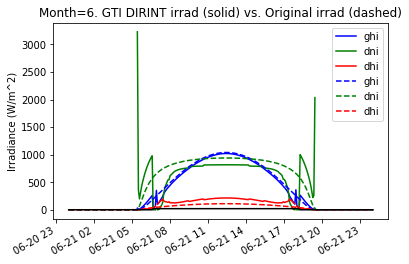

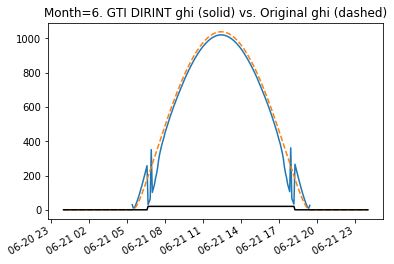

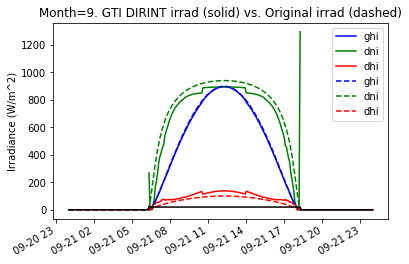

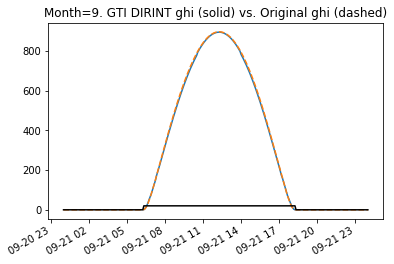

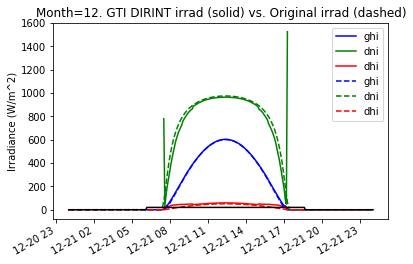

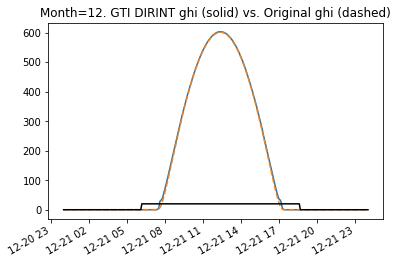

In [48]:
for month, data in gti_dirint_out.groupby(times.month):
    fig, ax = plt.subplots()
    data.plot(ax=ax, color=color)
    cs.loc[data.index].plot(ax=ax, ls='--', color=color)
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')  # please excuse the sloppy reuse of the axis
    ax.set_ylabel('Irradiance (W/m^2)')
    ax.set_title('Month={}. GTI DIRINT irrad (solid) vs. Original irrad (dashed)'.format(month))

    fig, ax = plt.subplots()
    data['ghi'].plot(ax=ax)
    cs.loc[data.index]['ghi'].plot(ax=ax, ls='--')
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')
    ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

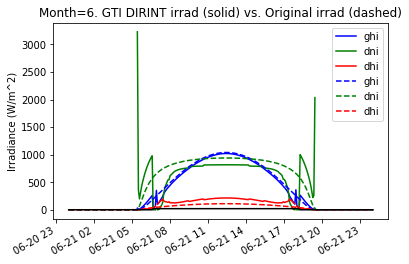

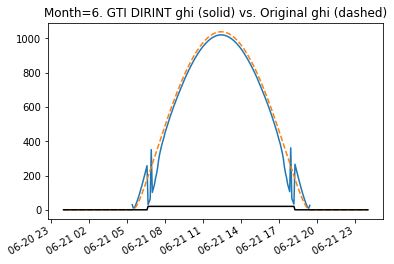

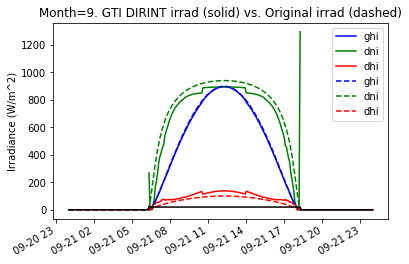

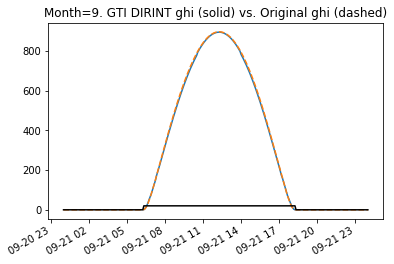

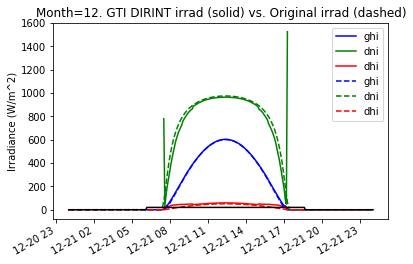

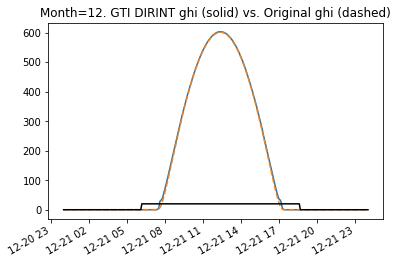

In [49]:
for month, data in gti_dirint_out.groupby(times.month):
    fig, ax = plt.subplots()
    data.plot(ax=ax, color=color)
    cs.loc[data.index].plot(ax=ax, ls='--', color=color)
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')  # please excuse the sloppy reuse of the axis
    ax.set_ylabel('Irradiance (W/m^2)')
    ax.set_title('Month={}. GTI DIRINT irrad (solid) vs. Original irrad (dashed)'.format(month))

    fig, ax = plt.subplots()
    data['ghi'].plot(ax=ax)
    cs.loc[data.index]['ghi'].plot(ax=ax, ls='--')
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')
    ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

Looks mostly reasonable for fall and winter.